# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В таблице 22 столбца.

Согласно документации к данным:  


* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* `balcony` — число балконов
* `ceiling_height` — высота потолков (м)
* `cityCenters_nearest` — расстояние до центра города (м)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
* `first_day_exposition` — дата публикации
* `floor` — этаж
* `floors_total` — всего этажей в доме
* `is_apartment` — апартаменты (булев тип)
* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* `last_price` — цена на момент снятия с публикации
* `living_area` — жилая площадь в квадратных метрах (м²)
* `locality_name` — название населённого пункта
* `open_plan` — свободная планировка (булев тип)
* `parks_around3000` — число парков в радиусе 3 км
* `parks_nearest` — расстояние до ближайшего парка (м)
* `ponds_around3000` — число водоёмов в радиусе 3 км
* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* `rooms` — число комнат
* `studio` — квартира-студия (булев тип)
* `total_area` — общая площадь квартиры в квадратных метрах (м²)
* `total_images` — число фотографий квартиры в объявлении
    
Как видно, количество значений в столбцах различается, а значит в данных имеются пропуски.

In [5]:
data.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

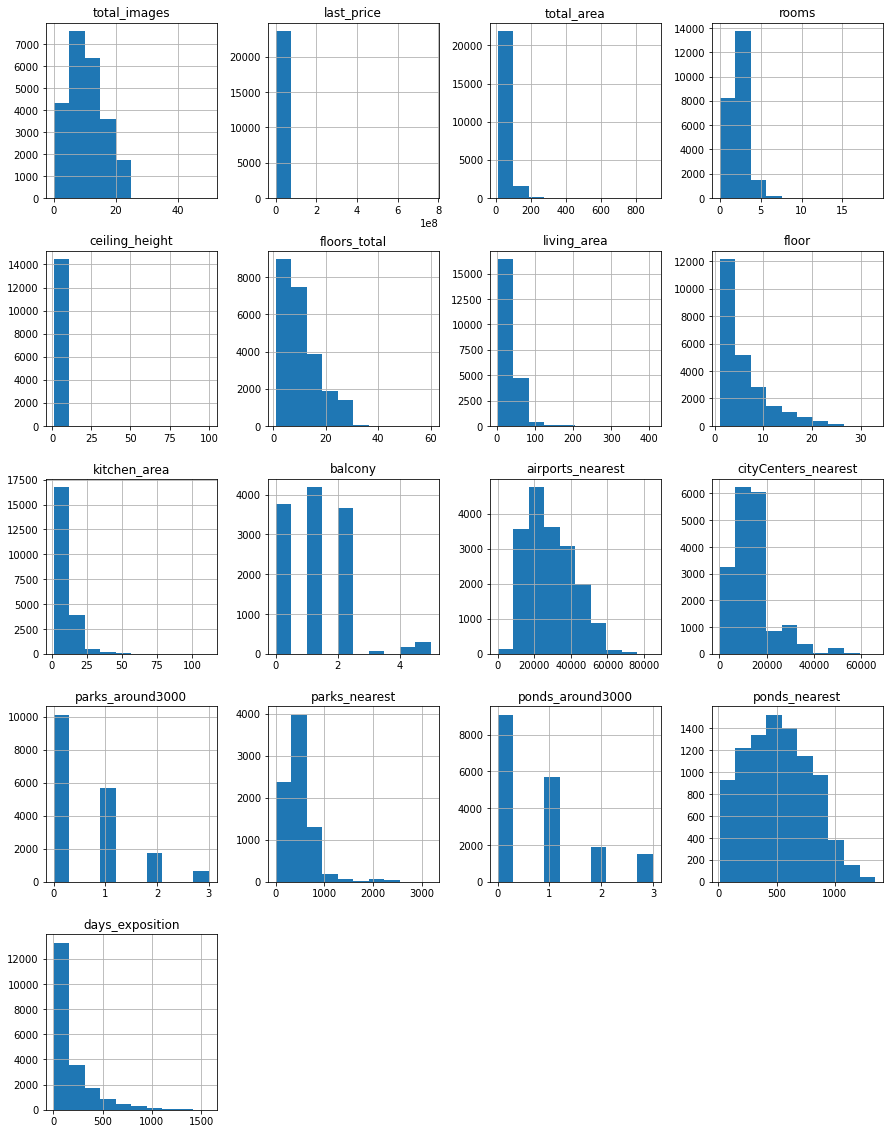

In [6]:
data.hist(figsize=(15,20))
plt.show()

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


При беглом взгляде на гистограммы и таблицу можно заметить, что в данных имеются выбивающиеся значения. Как, например, слишком низкие (1м) и слишком высокие (100м) потолки

### Предобработка данных

#### Заполнение пропусков

**Балконы**

In [8]:
data['balcony'].isna().sum()

11519

In [9]:
data['balcony'].fillna(0, inplace=True)

Чаще всего наличие балконов является важным параметром у квартиры и влияет на ее ценообразование. Поэтому можно предположить, что пропущенные значения в данном столбце значат, что в квартире вовсе нет балкона. Заменим пропуски на 0

In [10]:
data['balcony'].isna().sum()

0

**Потолки**

In [11]:
data['ceiling_height'].isna().sum()

9195

Поскольку ранее мы уже заметили, что высота потолков варьируется от 1 до 100 метров, замена пропусков на среднее значение может сильно исказить данные. Поэтому заполним их медианными значениями

In [12]:
ceiling_height_med = data['ceiling_height'].median()

In [13]:
data['ceiling_height'].fillna(ceiling_height_med, inplace=True)

In [14]:
data['ceiling_height'].isna().sum()

0

**Этажи**

In [15]:
data['floors_total'].isna().sum()

86

В столбце присутствуют 86 строк с пропущенными значениями. Поскольку это составляет менее 1%, замена пропусков особо не исказит данные. Наиболее логичным решением в данном случае будет заполнить пропуски по принципу: этаж, на котором находится квартира + 1 (чтобы квартира не оказалась на последнем этаже) 

In [16]:
data['floors_total'] = data['floors_total'].fillna(data['floor'] + 1)

In [17]:
data['floors_total'].isna().sum()

0

**Населеннный пункт**

In [18]:
data['locality_name'].isna().sum()

49

В данных имеется всего 49 строк с пропущенными названиями населенного пункта. Так как нет никакой возможности уточнить геоданные, корректно заполнить пропуски не представляется возможным. К тому же пропусков достаточно мало, в связи с чем мы можем просто удалить пропущенные значения. 

In [19]:
data = data.dropna(axis='index', how='any', subset=['locality_name'])

In [20]:
data['locality_name'].isna().sum()

0

**Длительность размещения объявления**

In [21]:
data['days_exposition'].isna().sum()

3180

В данных 3180 строк с пропущенными значениями. Они могли произойти из-за технического сбоя, либо объявления всё еще не сняты с публикации. Так как мы не можем выяснить точную причину или запросить дополнительную информацию, оставим эти поля пустыми.

**Площадь кухни**

In [22]:
data['kitchen_area'].isna().sum()

2269

В датасете имеется 2269 пропусков. Однако, прежде чем их заполнять, стоит обратить внимание, что у нас имеются квартиры-студии, где кухня объединена с жилой площадью. Следовательно в данных квартирах нельзя отдельно выделить площадь кухни. Стоит проверить есть ли среди данных квартир-студий пропуски в столбце с площадью кухни и заменить их на 0

In [23]:
data.loc[data['kitchen_area'].isna() & data['studio'] == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.65,24.0,15.50,2,NaN,True,False,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.65,17.0,24.75,4,NaN,True,False,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.65,10.0,NaN,7,NaN,True,False,NaN,0.0,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
697,12,2500000.0,24.10,2017-12-01T00:00:00,0,2.75,25.0,17.50,21,NaN,True,False,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0
716,5,1500000.0,17.00,2017-06-07T00:00:00,0,2.70,9.0,12.00,1,NaN,True,False,NaN,0.0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22867,8,3090000.0,30.00,2017-12-17T00:00:00,0,2.65,25.0,18.20,5,NaN,True,False,NaN,0.0,Санкт-Петербург,35250.0,16414.0,0.0,NaN,1.0,400.0,211.0
22877,2,4280000.0,28.00,2017-10-26T00:00:00,0,2.70,19.0,18.00,10,NaN,True,False,NaN,0.0,Санкт-Петербург,18982.0,7206.0,0.0,NaN,1.0,415.0,151.0
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,2.65,25.0,18.00,16,NaN,True,False,NaN,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,2.65,19.0,NaN,8,NaN,True,False,NaN,0.0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0


In [24]:
data.loc[data['studio'] == True, 'kitchen_area'] = 0

In [25]:
data.loc[data['kitchen_area'].isna() & data['studio'] == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [26]:
data['kitchen_area'].isna().sum()

2120

Таким образом мы заполнили 149 пропусков. Для заполнения остальных пропусков используем среднее соотношение площади кухни к общей площади квартиры. Таким образом, используя это соотношение вычислим значения площади кухни для пропусков.

In [27]:
kitchen_total_ratio = data['kitchen_area'].mean()/data['total_area'].mean()

In [28]:
data['kitchen_area'].fillna(kitchen_total_ratio*data['total_area'], inplace=True)

In [29]:
data['kitchen_area'].isna().sum()

0

**Жилая площадь**

In [30]:
data['living_area'].isna().sum()

1898

Аналогично площади кухни заменим 1898 имеющихся пропусков в жилой площади.

In [31]:
living_total_ratio = data['living_area'].mean()/data['total_area'].mean()

In [32]:
data['living_area'].fillna(living_total_ratio*data['total_area'], inplace=True)

In [33]:
data['living_area'].isna().sum()

0

**ВЫВОД**

In [34]:
data.isna().sum().sort_values(ascending=False)

is_apartment            20890
parks_nearest           15586
ponds_nearest           14565
airports_nearest         5534
cityCenters_nearest      5511
ponds_around3000         5510
parks_around3000         5510
days_exposition          3180
kitchen_area                0
locality_name               0
balcony                     0
total_images                0
last_price                  0
studio                      0
floor                       0
living_area                 0
floors_total                0
ceiling_height              0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

В датасете все еще имеются пропуски: 

* `is_apartment` - данные имеют булев тип и без запроса дополнительной информации мы никак не можем их заполнить 
* `days_exposition` - данные решено было оставить в таком виде
* `parks_nearest` - все последующие столбцы невозможно заполнить корректно без данных о геолокации
* `ponds_nearest` 
* `airports_nearest` 
* `cityCenters_nearest` 
* `ponds_around3000`
* `parks_around3000`


#### Исправление названия столбцов

In [35]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Исправим названия столбцов `cityCenters_nearest`, `parks_around3000`, `ponds_around3000`

In [36]:
data = data.rename(
    columns={
    'cityCenters_nearest': 'city_center_dist',
    'parks_around3000': 'parks_around_3000m',
    'ponds_around3000': 'ponds_around_3000m'}
)

In [37]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_center_dist',
       'parks_around_3000m', 'parks_nearest', 'ponds_around_3000m',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

#### Изменение типов данных

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Изменим тип данных в столбцах: `balcony`, `last_price`, `floors_total` на целочисленные для удобства подсчетов.

In [39]:
data = data.astype({'balcony': 'int', 'last_price': 'int', 'floors_total': 'int'})

Приведем столбец `first_day_exposition` к типу datetime

In [40]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          2760 non-null   object        
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

#### Поиск дубликатов

In [42]:
data.duplicated().sum()

0

Видно, что явных дубликатов в данных нет. Проверим на наличие неявных дубликатов

In [43]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

В списке присутствуют одинаковые названия, но с разным написанием буквы `ё`: поселок и посёлок. Чтобы не возникало путаницы, заменим все буквы `ё` на `е`

In [44]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)

In [45]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

Также в данных имеются похожие названия деревень и поселков, но без более детальной проверки сложно узнать один это населенный пункт или разные. Поэтому пока оставим данные названия без изменений

#### Редкие и выбивающиеся значения

Удалим редкие и выбивающиеся значения и сохраним срез в переменной `good_data`

In [46]:
good_data = data.copy()

##### Высота потолков

In [47]:
data['ceiling_height'].describe()

count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

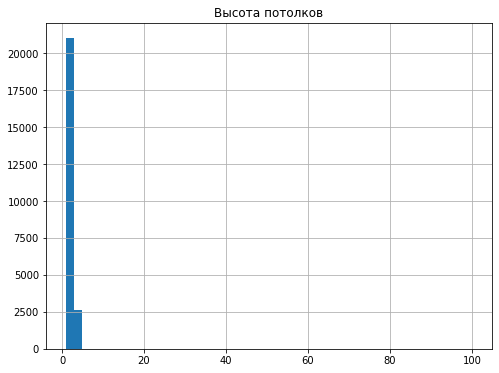

In [48]:
plt.figure(figsize=(8,6))
plt.hist(data["ceiling_height"], bins=50)
plt.title('Высота потолков')
plt.grid()
plt.show()

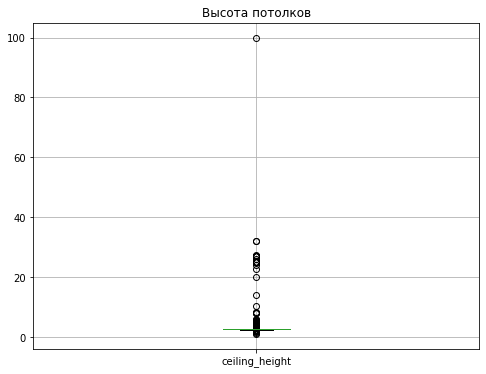

In [49]:
plt.figure(figsize=(8,6))
data.boxplot(column='ceiling_height')
plt.title('Высота потолков')
plt.show()

Как видно в данных имеется явный выброс в 100 м. Его можно просто удалить

In [50]:
good_data = data.query('ceiling_height != 100')

In [51]:
good_data['ceiling_height'].describe()

count    23649.000000
mean         2.720197
std          0.760597
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64

In [52]:
good_data.loc[good_data['ceiling_height'] > 20]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition
355,17,3600000,55.2,2018-07-12,2,25.0,5,32.0,2,False,False,False,9.601158,2,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
3148,14,2900000,75.0,2018-11-12,3,32.0,3,53.0,2,NaN,False,False,8.000000,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,0,4300000,45.0,2018-02-01,2,25.0,9,30.0,2,NaN,False,False,7.000000,1,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000,25.0,2017-09-27,0,27.0,25,17.0,17,NaN,False,True,4.348350,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000,30.5,2018-10-03,1,24.0,5,19.5,1,True,False,False,5.500000,0,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000,54.0,2017-10-13,2,27.0,5,30.0,3,NaN,False,False,9.000000,2,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5669,4,4400000,50.0,2017-08-08,2,26.0,9,21.3,3,NaN,False,False,7.000000,2,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
5807,17,8150000,80.0,2019-01-09,2,27.0,36,41.0,13,NaN,False,False,12.000000,5,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
6246,6,3300000,44.4,2019-03-25,2,25.0,5,31.3,5,NaN,False,False,5.700000,0,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
9379,5,3950000,42.0,2017-03-26,3,25.0,5,30.0,2,NaN,False,False,5.200000,0,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN


Как видно из графика и таблиц, в данных имеются слишком большие значения для высоты потолков. Логично предположить, что при вводе данных могли сделать ошибку и значения больше 20 на самом деле вещественные значения (27 вместо 2.7). Разделим их на 10

In [53]:
good_data['ceiling_height'] = good_data.apply(
                                    lambda i: i['ceiling_height']/10 
                                    if i['ceiling_height'] > 20  
                                    else i['ceiling_height'], axis=1
                                    )

In [54]:
good_data['ceiling_height'].describe()

count    23649.000000
mean         2.699072
std          0.272940
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         20.000000
Name: ceiling_height, dtype: float64

От слишком больших значений мы избавились. Но как видно остались и слишком маленькие значения. Высота потолков больше 5 метров также малоправдоподобна. Избавимся от значений меньше 2.2 метров и больше 5 метров

In [55]:
good_data.loc[good_data['ceiling_height'] < 2.2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition
552,11,2999000,33.50,2017-03-30,1,2.00,15,17.500000,6,NaN,False,False,6.500000,0,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
2572,4,2400000,62.00,2018-12-27,3,2.00,5,40.000000,4,NaN,False,False,6.000000,1,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,1,2120000,35.43,2017-12-18,1,2.00,18,16.600000,9,NaN,False,False,8.800000,2,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
5712,5,1500000,42.80,2017-08-14,2,1.20,2,27.500000,1,NaN,False,False,5.200000,0,городской поселок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5850,9,1650000,35.50,2018-05-29,1,2.00,5,20.270769,5,NaN,False,False,6.174658,0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0
11352,4,3300000,36.00,2017-06-18,1,2.00,17,15.200000,12,NaN,False,False,10.100000,0,поселок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0
16446,6,12300000,88.30,2019-03-12,3,2.00,5,63.900000,2,NaN,False,False,12.000000,0,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN
16884,0,1500000,33.00,2018-10-03,1,2.00,5,20.000000,5,False,False,False,6.000000,0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,6.0
16934,5,4100000,40.00,2017-10-17,1,1.75,37,17.400000,5,NaN,False,False,8.340000,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
19098,7,2700000,56.00,2018-02-04,3,2.00,5,46.000000,1,NaN,False,False,6.000000,0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,282.0


In [56]:
good_data.loc[good_data['ceiling_height'] > 5]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition
464,15,66571000,280.3,2015-06-11,6,5.2,8,159.500000,7,NaN,False,False,21.100000,0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1026,20,155000000,310.0,2018-10-12,5,5.3,3,190.000000,3,NaN,False,False,63.000000,2,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1388,20,59800000,399.0,2015-01-21,5,5.6,6,227.832023,6,NaN,False,False,69.399672,0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
3474,3,1400000,30.0,2018-03-16,1,8.0,5,15.300000,2,False,False,False,7.300000,0,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
5863,20,5650000,45.0,2018-08-15,1,8.3,16,19.300000,14,NaN,False,False,8.300000,1,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0
7578,17,38000000,143.0,2017-11-02,3,5.5,5,83.000000,5,NaN,False,False,29.000000,1,Санкт-Петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN
12628,14,3900000,50.0,2018-03-29,1,5.3,5,28.550379,5,NaN,False,False,8.696701,0,Санкт-Петербург,19644.0,3918.0,1.0,505.0,1.0,92.0,8.0
15061,19,5600000,56.4,2018-05-11,2,14.0,14,32.400000,5,NaN,False,False,9.100000,2,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
15743,14,5600000,67.0,2016-11-11,3,8.0,16,41.000000,1,NaN,False,False,8.000000,0,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
17442,0,5350000,54.0,2015-06-16,2,8.0,5,29.000000,2,NaN,False,False,9.392437,1,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0


In [57]:
good_data = good_data.query('ceiling_height > 2.2 and ceiling_height < 5')

Данные очищены от аномальных значений, можем двигаться дальше.

##### Стоимость квартиры

In [58]:
good_data['last_price'].describe().apply('{0:.2f}'.format)

count        23619.00
mean       6526375.42
std       10820644.48
min          12190.00
25%        3400000.00
50%        4650000.00
75%        6799000.00
max      763000000.00
Name: last_price, dtype: object

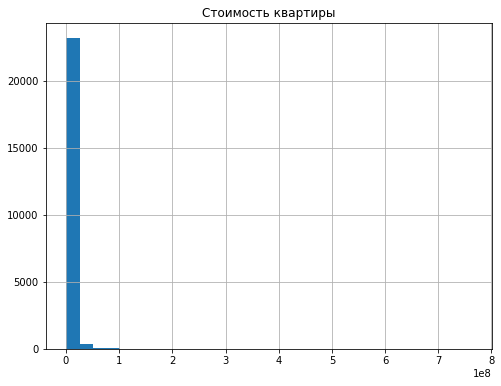

In [59]:
plt.figure(figsize=(8,6))
plt.hist(good_data["last_price"], bins=30)
plt.title('Стоимость квартиры')
plt.grid()
plt.show()

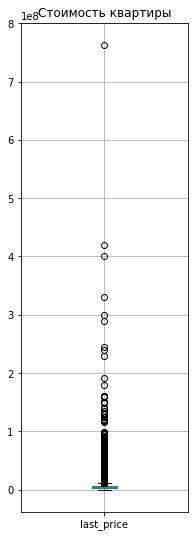

In [60]:
good_data.boxplot('last_price', figsize=(3, 9))
plt.title('Стоимость квартиры')
plt.show()

Из графиков и таблицы видно, что большая часть квартир имеет цену до 12млн. Максимальная цена квартиры составляет 763млн, минимальная стоимость - 12190 рублей (скорее всего это была ошибка при вводе данных). 
Есть довольно большой разрыв между средней (6.5млн. рублей) и медианной ценой(4.7млн. рублей), так как сверхдорогие квартиры сдвигают распределение. Также можно отметить, что выбивающиеся значения стоимости квартир могут представлять собой сегмент элитной недвижимости. Было бы более правильным выделить данные в отельный сегмент и исследовать отдельно, но в рамках данного проекта мы уберем редкие и выбивающиеся значения.

In [61]:
good_data.loc[good_data['last_price'] < 20000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition
8793,7,12190,109.0,2019-03-20,2,2.75,25,32.0,25,NaN,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


In [62]:
good_data.loc[good_data['last_price'] > 12000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,NaN,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
3,0,64900000,159.0,2015-07-24,3,2.65,14,90.790205,9,NaN,False,False,27.655508,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
19,16,14200000,121.0,2019-01-09,3,2.75,16,76.000000,8,NaN,False,False,12.000000,0,Санкт-Петербург,38900.0,12843.0,0.0,NaN,0.0,NaN,97.0
35,6,15500000,149.0,2017-06-26,5,2.65,5,104.000000,4,NaN,False,False,17.000000,0,Санкт-Петербург,23670.0,3502.0,0.0,NaN,1.0,779.0,644.0
42,13,22000000,161.8,2015-07-08,4,2.80,4,80.900000,2,False,False,False,17.600000,5,Петергоф,35416.0,30605.0,2.0,47.0,1.0,907.0,987.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23587,7,12100000,88.0,2017-07-07,3,2.65,10,50.248667,5,NaN,False,False,14.000000,0,Санкт-Петербург,37412.0,8370.0,1.0,392.0,2.0,359.0,200.0
23590,0,21187872,123.3,2017-04-25,3,2.65,19,50.400000,18,NaN,False,False,23.600000,0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0
23608,22,14000000,80.0,2017-11-10,3,2.65,11,44.100000,6,NaN,False,False,11.000000,2,Санкт-Петербург,11943.0,11710.0,1.0,518.0,1.0,232.0,19.0
23631,17,14799000,104.0,2018-11-18,3,3.10,4,66.000000,2,NaN,False,False,14.000000,1,Санкт-Петербург,39047.0,13944.0,0.0,NaN,1.0,553.0,90.0


In [63]:
good_data = good_data.query('last_price > 20000 & last_price <= 12000000')

In [64]:
good_data['last_price'].describe().apply('{0:.2f}'.format)

count       21689.00
mean      4879711.55
std       2272707.59
min        430000.00
25%       3300000.00
50%       4410000.00
75%       6000000.00
max      12000000.00
Name: last_price, dtype: object

Данные приведены в порядок, удалены редкие и выбивающиеся значения.

##### Количество комнат

In [65]:
good_data['rooms'].describe().apply('{0:.2f}'.format)

count    21689.00
mean         1.94
std          0.92
min          0.00
25%          1.00
50%          2.00
75%          3.00
max          7.00
Name: rooms, dtype: object

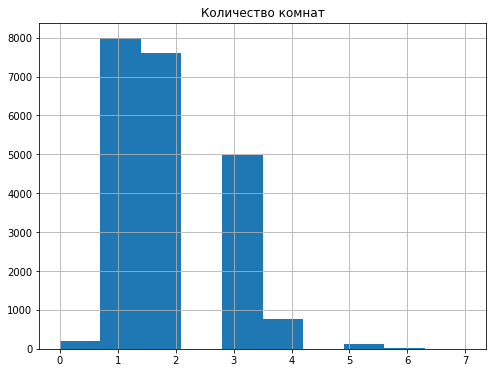

In [66]:
plt.figure(figsize=(8,6))
plt.hist(good_data["rooms"], bins=10)
plt.title('Количество комнат')
plt.grid()
plt.show()

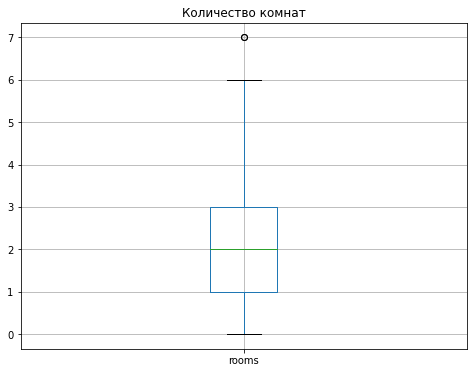

In [67]:
plt.figure(figsize=(8,6))
good_data.boxplot('rooms')
plt.title('Количество комнат')
plt.show()

Большинство квартир имеют от 1 до 3 комнат. Разброс нормальных значений от 0 (квартиры-студии) до 6 комнат. В данном случае имеется одно выбивающиеся значение - 7 комнат. Удалим его.

In [68]:
good_data = good_data.query('rooms <= 6')

In [69]:
good_data['rooms'].describe().apply('{0:.2f}'.format)

count    21687.00
mean         1.94
std          0.92
min          0.00
25%          1.00
50%          2.00
75%          3.00
max          6.00
Name: rooms, dtype: object

##### Площадь квартир

In [70]:
good_data['total_area'].describe().apply('{0:.2f}'.format)

count    21687.00
mean        53.50
std         19.38
min         12.00
25%         39.00
50%         49.50
75%         64.00
max        230.00
Name: total_area, dtype: object

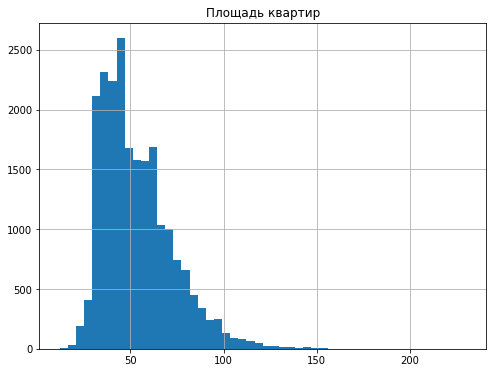

In [71]:
plt.figure(figsize=(8,6))
plt.hist(good_data["total_area"], bins=50)
plt.title('Площадь квартир')
plt.grid()
plt.show()

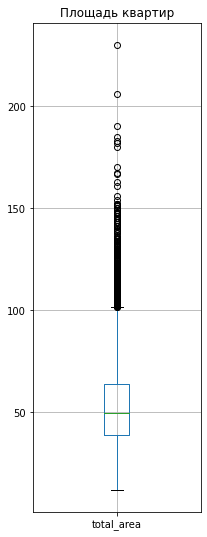

In [72]:
good_data.boxplot('total_area', figsize=(3, 9))
plt.title('Площадь квартир')
plt.show()

Из диаграммы мы видим, что разброс нормальных значений от 15кв.м до 100кв.м.
В данных присутсвуют даже квартиры более 230кв.м. Уберем редкие и выбивающиеся значения.

In [73]:
good_data.loc[good_data['total_area'] > 150]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition
869,14,10335000,170.0,2017-09-11,5,3.00,16,81.000000,11,NaN,False,False,29.568783,0,Санкт-Петербург,46411.0,15247.0,1.0,672.0,0.0,NaN,35.0
2759,11,7500000,152.0,2018-07-27,3,3.00,3,86.793151,1,True,False,False,26.437970,1,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,7.0
5500,10,11997000,166.9,2017-11-28,6,2.95,5,107.000000,4,NaN,False,False,18.700000,0,Санкт-Петербург,24232.0,4800.0,1.0,172.0,0.0,NaN,365.0
5659,2,11067416,160.7,2018-08-01,2,3.00,2,91.760917,1,NaN,False,False,27.951196,0,поселок Репино,61451.0,42550.0,0.0,NaN,0.0,NaN,238.0
5837,6,4500000,185.0,2018-08-14,3,2.65,3,62.000000,2,NaN,False,False,22.000000,0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6247,8,9600000,180.1,2017-03-07,4,2.75,2,100.000000,2,NaN,False,False,19.500000,1,Зеленогорск,73547.0,54646.0,0.0,NaN,1.0,1037.0,496.0
7041,13,9700000,156.0,2016-09-13,4,3.30,7,79.000000,5,NaN,False,False,13.300000,0,Санкт-Петербург,23571.0,3113.0,0.0,NaN,0.0,NaN,884.0
7399,3,11000000,230.0,2018-03-01,5,2.50,2,131.331742,2,NaN,False,False,40.004824,0,деревня Хязельки,NaN,NaN,NaN,NaN,NaN,NaN,419.0
7756,1,4390000,151.8,2017-04-28,6,3.50,6,106.500000,6,False,False,False,14.300000,1,Санкт-Петербург,24576.0,2270.0,0.0,NaN,0.0,NaN,44.0
8732,20,9300000,151.5,2017-06-27,4,3.00,3,57.100000,1,NaN,False,False,7.700000,0,Павловск,19575.0,31729.0,2.0,292.0,1.0,605.0,513.0


In [74]:
good_data = good_data.query('total_area <= 150')

##### Срок размещения объявления

In [75]:
good_data['days_exposition'].describe()

count    19015.000000
mean       173.359926
std        212.025569
min          1.000000
25%         44.000000
50%         91.000000
75%        219.000000
max       1580.000000
Name: days_exposition, dtype: float64

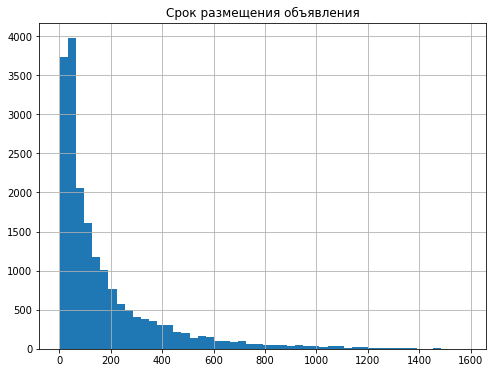

In [76]:
plt.figure(figsize=(8,6))
plt.hist(good_data["days_exposition"], bins=50)
plt.title('Срок размещения объявления')
plt.grid()
plt.show()

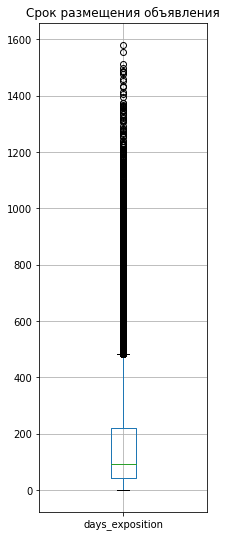

In [77]:
good_data.boxplot('days_exposition', figsize=(3, 9))
plt.title('Срок размещения объявления')
plt.show()

Большая часть значений находится в диапазоне до 43 до 216 дней. Разброс нормальных значений от 1 до 510. Отметим, что в данных есть несколько значений менее 3 дней. Вполне вероятно, что люди, разместившие объявления по каким-то причинам его сняли. Разница между средним значением и медианой почти два раза. Это объясняется тем, что в распределении длинный хвост высоких значений, которые перетягивают среднее вправо. Максимальное значение - 1580 дней. Уберем редкие и выбивающиеся значения используя квантили 0.005 и 0.995 как лимиты.

In [78]:
good_data = good_data.query('days_exposition > @good_data["days_exposition"].quantile(q=0.005) and days_exposition <= @good_data["days_exposition"].quantile(q=0.995)')

In [79]:
good_data['days_exposition'].describe()

count    18761.000000
mean       169.121156
std        197.364027
min          4.000000
25%         44.000000
50%         92.000000
75%        218.000000
max       1153.000000
Name: days_exposition, dtype: float64

Посмотрим сколько данных нам пришлось отбросить.

In [80]:
print(f'Нам пришлось отбросить: {1 - good_data.shape[0] / data.shape[0]:.2%}')

Нам пришлось отбросить: 20.67%


### Новые столбцы

#### Расчет цены одного квадратного метра

In [81]:
good_data['price_per_sqm'] = good_data['last_price'] / good_data['total_area']

In [82]:
good_data['price_per_sqm'] = good_data['price_per_sqm'].astype('int')

In [83]:
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition,price_per_sqm
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,NaN,False,False,9.1,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,NaN,False,False,14.4,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195


#### День недели публикации объявления

In [84]:
good_data['weekday'] = good_data['first_day_exposition'].dt.weekday

#### Месяц публикации объявления

In [85]:
good_data['month'] = good_data['first_day_exposition'].dt.month

#### Год публикации объявления

In [86]:
good_data['year'] = good_data['first_day_exposition'].dt.year

In [87]:
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition,price_per_sqm,weekday,month,year
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,NaN,False,False,9.1,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065,0,9,2018
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,NaN,False,False,14.4,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195,3,11,2017


#### Тип этажа квартиры

Напишем функцию для разделения этажей на категории: первый, последний, другой.

In [88]:
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

good_data['floor_category'] = good_data.apply(floor_category, axis=1)

In [89]:
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition,price_per_sqm,weekday,month,year,floor_category
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,NaN,False,False,9.1,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065,0,9,2018,другой
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,NaN,False,False,14.4,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195,3,11,2017,другой


#### Расстояние до центра города в км

In [90]:
good_data['city_center_dist_km'] = np.round(good_data['city_center_dist']/1000, 0)

In [91]:
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_dist,parks_around_3000m,parks_nearest,ponds_around_3000m,ponds_nearest,days_exposition,price_per_sqm,weekday,month,year,floor_category,city_center_dist_km
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой,14.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой,8.0
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,NaN,False,False,9.1,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065,0,9,2018,другой,NaN
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,NaN,False,False,14.4,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195,3,11,2017,другой,19.0


### Исследовательский анализ данных

#### Изучение параметров

##### Общая площадь квартиры

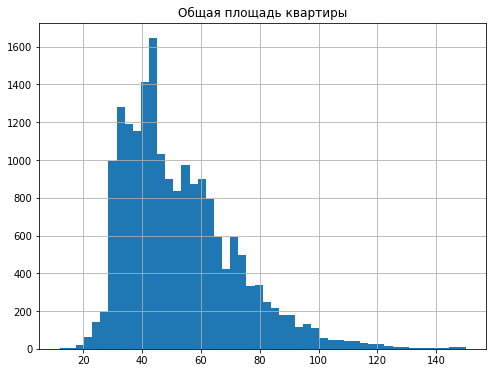

In [92]:
plt.figure(figsize=(8,6))
plt.hist(good_data['total_area'], bins=50)
plt.title('Общая площадь квартиры')
plt.grid()
plt.show()

In [93]:
good_data['total_area'].describe().apply('{0:.2f}'.format)

count    18761.00
mean        52.86
std         18.87
min         12.00
25%         38.70
50%         48.50
75%         63.00
max        150.00
Name: total_area, dtype: object

Гистограмма по общей площади квартир имеет пик в районе 45кв.м. Большая часть квартир имеет площадь 38-63 кв.м. Средняя площадь 53 кв.м, медиана 48.50 кв.м, а минимальная площадь 12кв.м, но таких квартир немного.

##### Жилая площадь

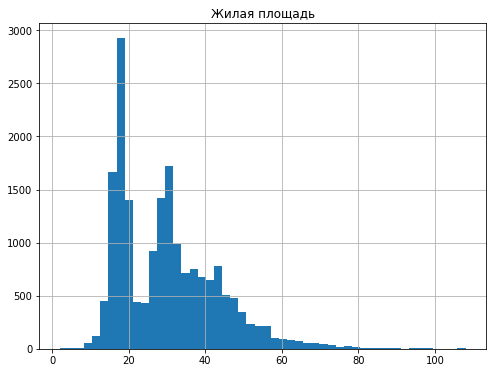

In [94]:
plt.figure(figsize=(8,6))
plt.hist(good_data['living_area'], bins=50)
plt.title('Жилая площадь')
plt.grid()
plt.show()

In [95]:
good_data['living_area'].describe()

count    18761.000000
mean        30.215448
std         13.223721
min          2.000000
25%         18.200000
50%         29.000000
75%         38.500000
max        108.000000
Name: living_area, dtype: float64

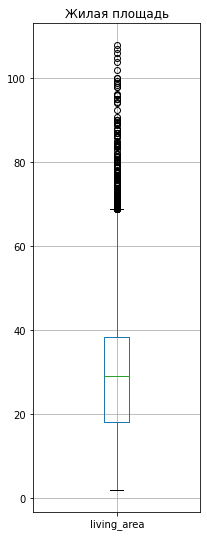

In [96]:
good_data.boxplot('living_area', figsize=(3, 9))
plt.title('Жилая площадь')
plt.show()

Из данных видно, что жилая площадь большинства квартир находится в диапазоне от 18.2 до 38.5 кв.м. Разброс нормальных значений от 2кв.м. до 63кв.м. Также видно, что имеются выбивающиеся значения - квартиры с жилой площадью от 65 кв.м. до 108 кв.м.

##### Площадь кухни

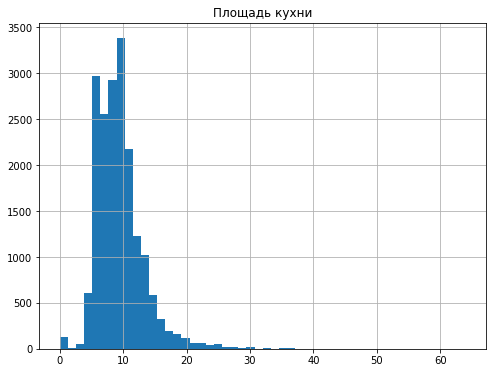

In [97]:
plt.figure(figsize=(8,6))
plt.hist(good_data['kitchen_area'], bins=50)
plt.title('Площадь кухни')
plt.grid()
plt.show()

In [98]:
good_data['kitchen_area'].describe()

count    18761.000000
mean         9.479509
std          3.865804
min          0.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         64.000000
Name: kitchen_area, dtype: float64

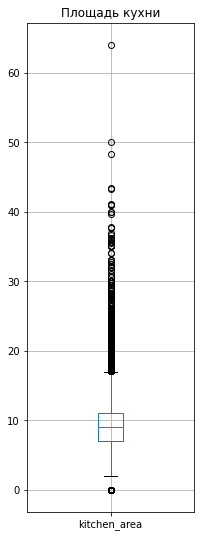

In [99]:
good_data.boxplot('kitchen_area', figsize=(3, 9))
plt.title('Площадь кухни')
plt.show()

Большинство кухонь имеет площадь в районе 9кв.м. Максимальное имеющиеся значение составляет 64кв.м. Минимальное значение в 0 кв.м. не является аномалией, а относится к квартирам-студиям, где кухня совмещена с жилой площадью. Однако имеется немало выбивающихся значений от 15 до 64 кв.м.

##### Цена квартиры

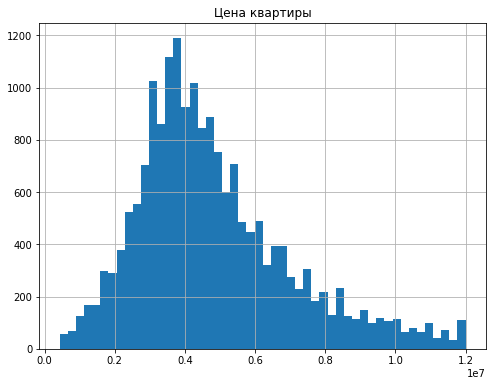

In [100]:
plt.figure(figsize=(8,6))
plt.hist(good_data['last_price'], bins=50)
plt.title('Цена квартиры')
plt.grid()
plt.show()

In [101]:
good_data['last_price'].describe().apply('{0:.2f}'.format)

count       18761.00
mean      4803746.22
std       2207162.99
min        430000.00
25%       3300000.00
50%       4350000.00
75%       5900000.00
max      12000000.00
Name: last_price, dtype: object

Большая часть квартир стоит от 3.300.000 рублей до 5.900.000 рублей с медианным значением 4.350.000 рублей

##### Количество комнат

In [102]:
good_data['rooms'].describe().apply('{0:.2f}'.format)

count    18761.00
mean         1.91
std          0.90
min          0.00
25%          1.00
50%          2.00
75%          3.00
max          6.00
Name: rooms, dtype: object

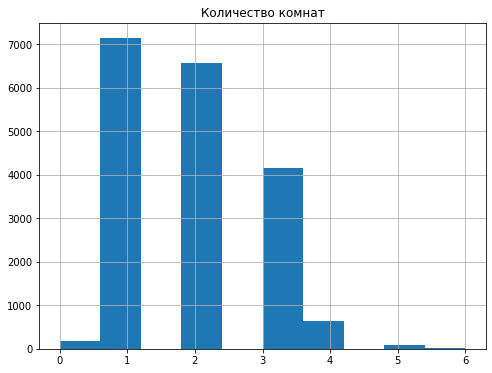

In [103]:
plt.figure(figsize=(8,6))
plt.hist(good_data["rooms"], bins=10)
plt.title('Количество комнат')
plt.grid()
plt.show()

Большая часть квартир имеют 1-3 комнаты с перевесом в сторону однокомнатных.Меньше всего квартир с 6, 5 и 0 комнатами.

##### Высота потолков

In [104]:
good_data['ceiling_height'].describe().apply('{0:.2f}'.format)

count    18761.00
mean         2.67
std          0.17
min          2.25
25%          2.60
50%          2.65
75%          2.65
max          4.70
Name: ceiling_height, dtype: object

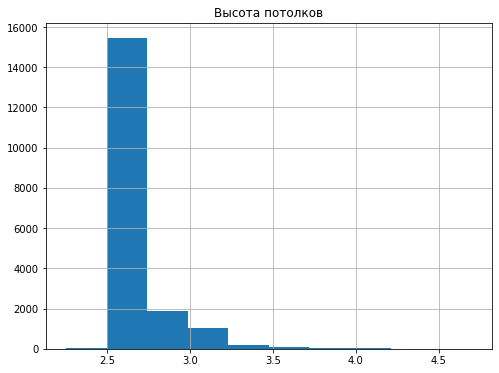

In [105]:
plt.figure(figsize=(8,6))
plt.hist(good_data['ceiling_height'], bins=10)
plt.title('Высота потолков')
plt.grid()
plt.show()

Большая часть квартир имеет высоту потолков от 2.60м до 2.65м. Среднее практически равно медиане и также составляет 2.67м. Максимально высокие потолки имеют высоту 4.70м.

##### Этаж квартиры

In [106]:
good_data['floor'].describe()

count    18761.000000
mean         5.987741
std          4.961897
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

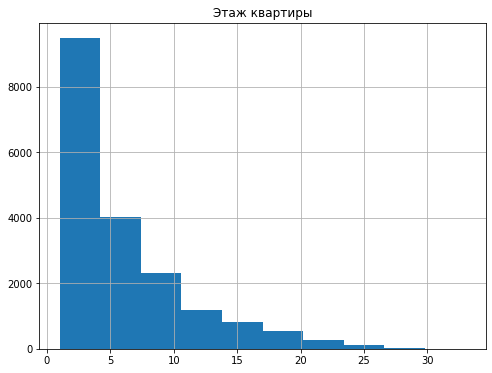

In [107]:
plt.figure(figsize=(8,6))
plt.hist(good_data['floor'], bins=10)
plt.title('Этаж квартиры')
plt.grid()
plt.show()

Больше всего квартир расположены с первого по четвертый этажи. Максимальный этаж 31, количество квартир резко уменьшается после 8 этажа.

##### Тип этажа

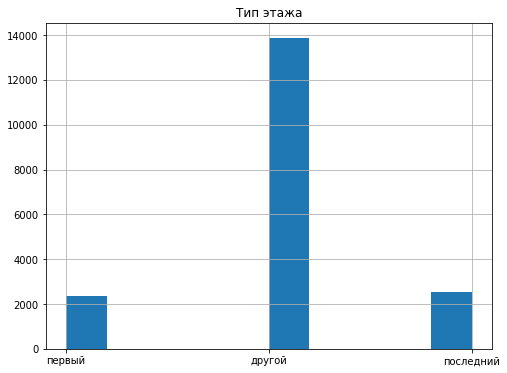

In [108]:
plt.figure(figsize=(8,6))
plt.hist(good_data['floor_category'], bins=10)
plt.title('Тип этажа')
plt.grid()
plt.show()

Как видно из гистограммы большинство квартир находится в категории "другой" - около 14000. На первом и последнем этажах находится приблизительно одинаковое количество квартир - чуть больше 2000.

##### Общее количество этажей в доме

In [109]:
good_data['floors_total'].describe().apply('{0:.2f}'.format)

count    18761.00
mean        10.95
std          6.68
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: object

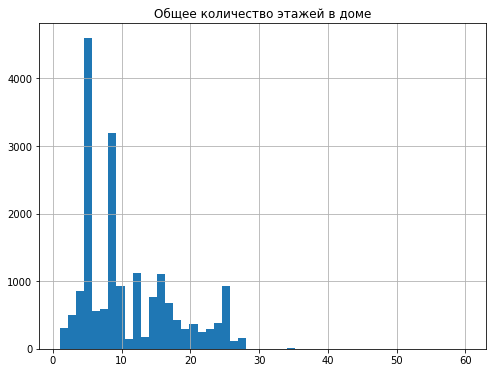

In [110]:
plt.figure(figsize=(8,6))
plt.hist(good_data['floors_total'], bins=50)
plt.title('Общее количество этажей в доме')
plt.grid()
plt.show()

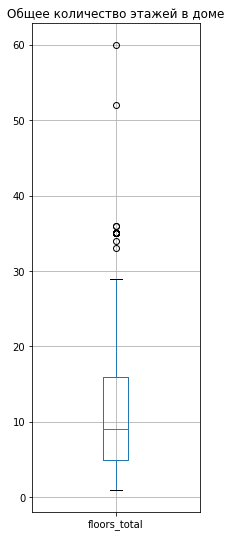

In [111]:
good_data.boxplot('floors_total', figsize=(3, 9))
plt.title('Общее количество этажей в доме')
plt.show()

Больше всего квартир расположено в невысотных домах от 5 до 16 этажей, с пиками в районе 5 и 9 этажей. Также видно, что имеются выбивающиеся значения - более 28 этажей, но таких высотных домов не много.

##### Расстояние до центра в метрах

In [112]:
good_data['city_center_dist'].describe().apply('{0:.2f}'.format)

count    14185.00
mean     14950.61
std       8469.98
min        208.00
25%      10643.00
50%      13615.00
75%      16699.00
max      65105.00
Name: city_center_dist, dtype: object

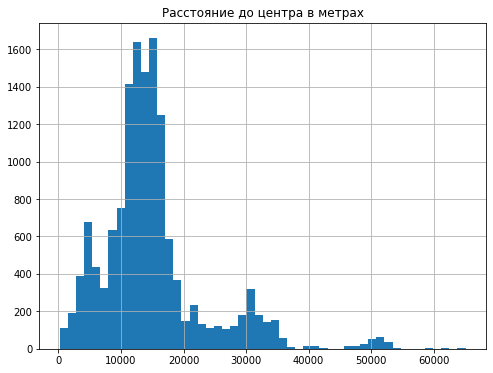

In [113]:
plt.figure(figsize=(8,6))
plt.hist(good_data['city_center_dist'], bins=50)
plt.title('Расстояние до центра в метрах')
plt.grid()
plt.show()

Большинство квартир расположено в пределах 10912-16788 метров от центра. Самая удаленная квартиры от центра расположена в 65105 метрах. Количество квартир начинает резко уменьшаться начиная от 18000 метров и имеет небольшой пик лишь в районе 30000 метров 

##### Расстояние до аэропорта

In [114]:
good_data['airports_nearest'].describe().apply('{0:.2f}'.format)

count    14172.00
mean     28955.88
std      12999.42
min          0.00
25%      18079.00
50%      27107.00
75%      37783.75
max      84006.00
Name: airports_nearest, dtype: object

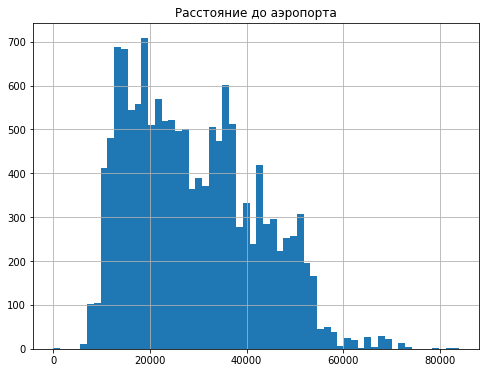

In [115]:
plt.figure(figsize=(8,6))
plt.hist(good_data['airports_nearest'], bins=60)
plt.title('Расстояние до аэропорта')
plt.grid()
plt.show()

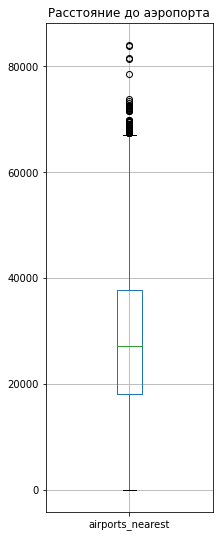

In [116]:
good_data.boxplot('airports_nearest', figsize=(3, 9))
plt.title('Расстояние до аэропорта')
plt.show()

Большинство квартир расположено в пределах от 18079 до 37783 метров от аэропорта. Самая удаленная квартира от аэропорта расположена в 84006 метрах. Количество квартир начинает резко уменьшаться начиная от 50000 метров.

##### Расстояние до парка

In [117]:
good_data['parks_nearest'].describe().apply('{0:.2f}'.format)

count    5877.00
mean      488.38
std       330.82
min         1.00
25%       288.00
50%       454.00
75%       613.00
max      3190.00
Name: parks_nearest, dtype: object

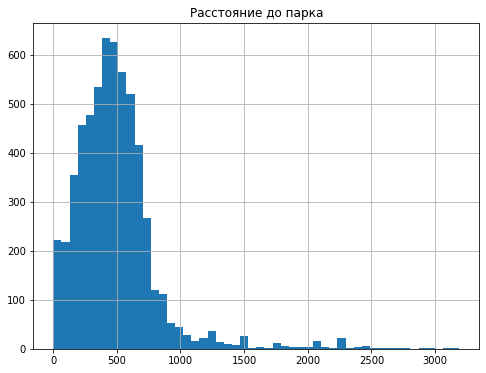

In [118]:
plt.figure(figsize=(8,6))
plt.hist(good_data['parks_nearest'], bins=50)
plt.title('Расстояние до парка')
plt.grid()
plt.show()

Большинство квартир расположено в пределах от 288 до 613 метров от ближайшего парка. Самая удаленная квартира от парка расположена в 3190 метрах. Количество квартир начинает резко уменьшаться начиная от 750 метров.

##### День и месяц публикации

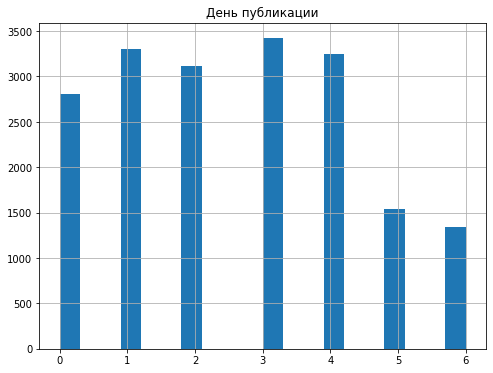

In [119]:
plt.figure(figsize=(8,6))
plt.hist(good_data['weekday'], bins=20)
plt.title('День публикации')
plt.grid()
plt.show()

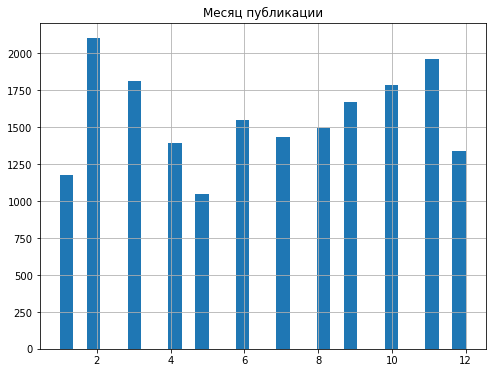

In [120]:
plt.figure(figsize=(8,6))
plt.hist(good_data['month'], bins=30)
plt.title('Месяц публикации')
plt.grid()
plt.show()

Меньше всего публикаций было сделано в выходные дни (в субботу чуть больше, чем в воскресенье). Чаще всего опубликовывали объявления во вторник, четверг и пятницу. 

Что касается месяца публикации: больше всего объявлений было размещено в феврале и ноябре. После февраля наблюдается спад, который достигает максимума в мае. После мая опять начинается увеличение количества объявлений с резким падением в конце года (в декабре)

#### Скорость продажи квартиры

In [121]:
good_data['days_exposition'].describe().apply('{0:.2f}'.format)

count    18761.00
mean       169.12
std        197.36
min          4.00
25%         44.00
50%         92.00
75%        218.00
max       1153.00
Name: days_exposition, dtype: object

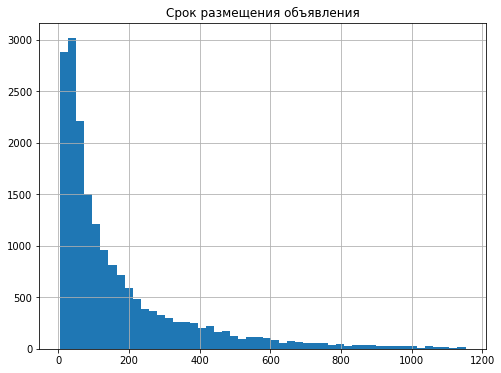

In [122]:
plt.figure(figsize=(8,6))
good_data['days_exposition'].hist(bins=50)
plt.title('Срок размещения объявления')
plt.show()

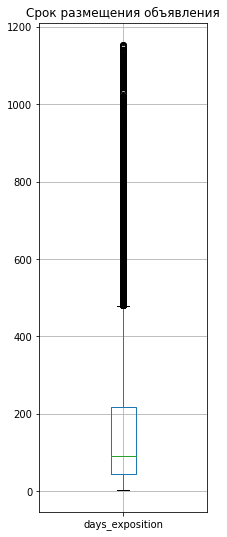

In [123]:
good_data.boxplot('days_exposition', figsize=(3, 9))
plt.title('Срок размещения объявления')
plt.show()

In [124]:
print(f'Среднее время продажи квартиры: {good_data["days_exposition"].mean():.0f} дней')
print(f'Медианное время продажи квартиры: {good_data["days_exposition"].median():.0f} дней')

Среднее время продажи квартиры: 169 дней
Медианное время продажи квартиры: 92 дней


Изучив данные и графики, можно сделать вывод, что продажа прошла быстро, если с момента публикации прошло менее 44 дней. А слишком долго, если объявление было опубликовано более 510 дней. Большинство объявлений были размещены от 44 до 218 дней, с медианой в 92 дней.

#### Факторы, влияющие на стоимость квартиры

##### Общая площадь квартиры

Посмотрим как общая площадь квартиры влияет на ее стоимость. Для этого посчитаем коэффициент корреляции и построим диаграмму рассеяния.

In [125]:
good_data['total_area'].corr(good_data['last_price'])

0.7159021731385762

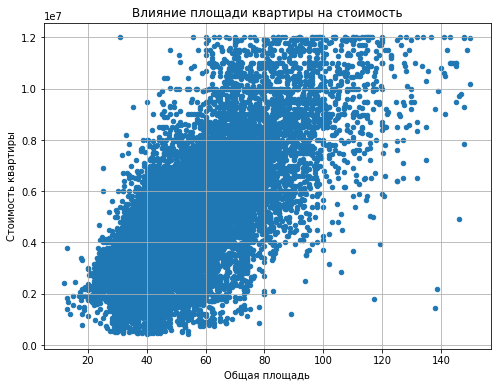

In [126]:
good_data.plot(x='total_area', y='last_price', kind='scatter', grid=True, figsize=(8,6))
plt.title('Влияние площади квартиры на стоимость')
plt.xlabel('Общая площадь')
plt.ylabel('Стоимость квартиры')
plt.show()

Коэффициент корреляции составляет 0.72, что говорит о сильной положительной взаимосвязи между общей площадью и стоимостью квартиры. Также и по диаграмме рассеяния видно, что есть зависимость стоимости квартиры от общей площади, хотя есть и выбивающиеся значения.

##### Жилая площадь

In [127]:
good_data['living_area'].corr(good_data['last_price'])

0.5992594986910883

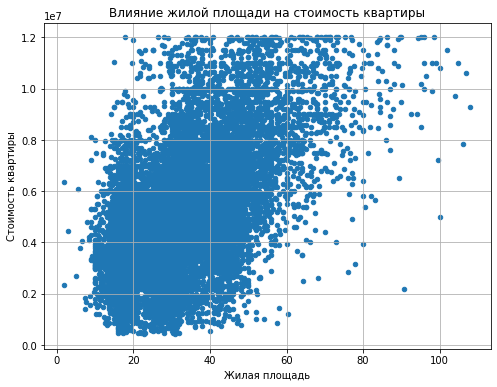

In [128]:
good_data.plot(x='living_area', y='last_price', kind='scatter', grid=True, figsize=(8,6))
plt.title('Влияние жилой площади на стоимость квартиры')
plt.xlabel('Жилая площадь')
plt.ylabel('Стоимость квартиры')
plt.show()

Глядя на полученные данные, можно заметить, что между жилой площадью и стоимостью квартиры имеется положительная связь: чем больше жилая площадь, тем выше стоимость квартиры

##### Площадь кухни

Проверим есть ли зависимость между стоимостью квартиры и площадью кухни

In [129]:
good_data['kitchen_area'].corr(good_data['last_price'])

0.5150739538729098

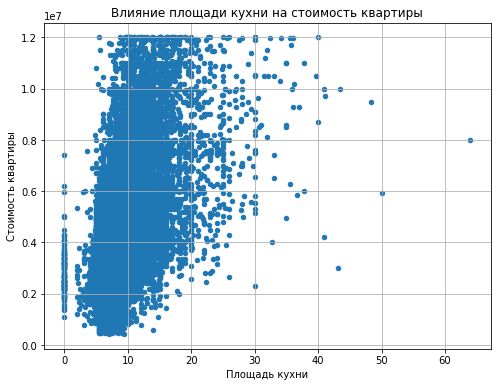

In [130]:
good_data.plot(x='kitchen_area', y='last_price', kind='scatter', grid=True, figsize=(8,6))
plt.title('Влияние площади кухни на стоимость квартиры')
plt.xlabel('Площадь кухни')
plt.ylabel('Стоимость квартиры')
plt.show()

Исходя из коэффициента корреляции и диаграммы рассеяния нельзя с уверенностью сказать, что существует зависимость между площадью кухни и стоимостью квартиры

##### Количество комнат

Посмотрим как число комнат в квартире влияет на её стоимость. Для этого посчитаем коэффициент корреляции и построим диаграмму рассеяния.

In [131]:
good_data['rooms'].corr(good_data['last_price'])

0.4645984865531757

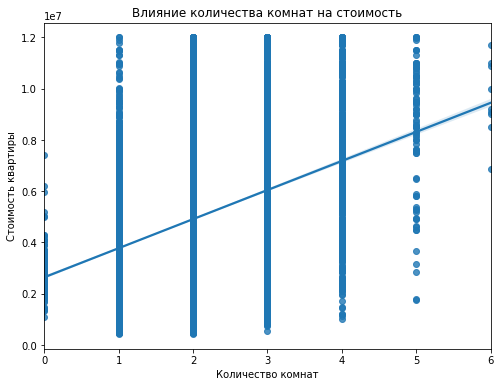

In [132]:
plt.figure(figsize=(8,6))
sns.regplot(data=good_data, x='rooms', y='last_price')
plt.title('Влияние количества комнат на стоимость')
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость квартиры')
plt.show()

Коэффициент корреляции составляет 0.47, что говорит о средней положительной корреляции между факторами. По графику видно что есть прямая зависимость стоимости от числа комнат.

##### Тип этажа

Посмотрим как этаж, на котором расположена квартира влияет на её стоимость. Для этого построим диаграмму размаха по трем категориям - первый, последний, другой.

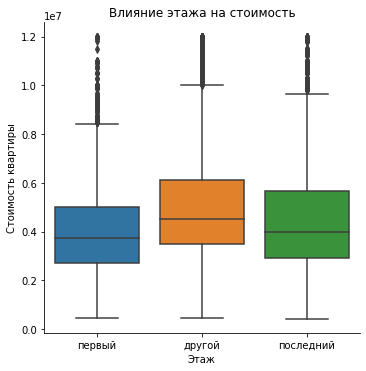

In [133]:
sns.catplot(data=good_data, x='floor_category', y='last_price', kind='box')
plt.title('Влияние этажа на стоимость')
plt.xlabel('Этаж')
plt.ylabel('Стоимость квартиры')
plt.show()

Самая низкая стоимость у квартир, расположенных на первом этаже, а самая высокая у квартир на этажах между первым и последним.

##### Дата размещения объявления

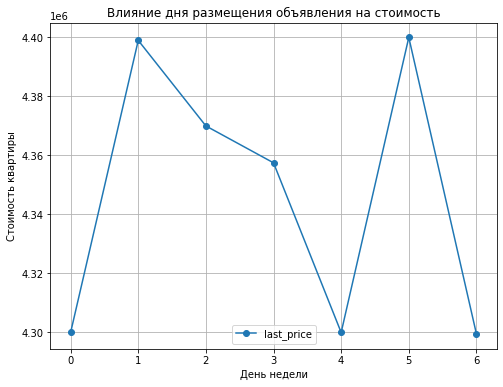

In [134]:
good_data.pivot_table(index='weekday', values='last_price', aggfunc='median').plot(y='last_price', style='o-', grid=True, figsize=(8,6))
plt.title('Влияние дня размещения объявления на стоимость')
plt.xlabel("День недели")
plt.ylabel("Стоимость квартиры")
plt.show()

Цена на квартиры растет в понедельник, достигая пика во вторник и начинает падать со среды до пятницы, затем снова резко растет в субботу с резким падением в воскресенье

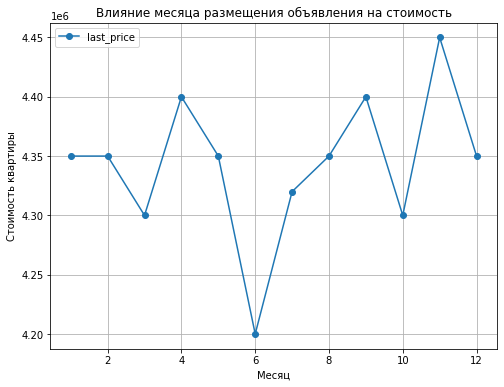

In [135]:
good_data.pivot_table(index='month', values='last_price', aggfunc='median').plot(y='last_price', style='o-', grid=True, figsize=(8,6))
plt.title('Влияние месяца размещения объявления на стоимость')
plt.xlabel("Месяц")
plt.ylabel("Стоимость квартиры")
plt.show()

Цены на квартиры растут с октября до ноября, а также с марта по апрель. После чего начинают резко падать достигая минимума в июне. После июня начинается рост до сентября.

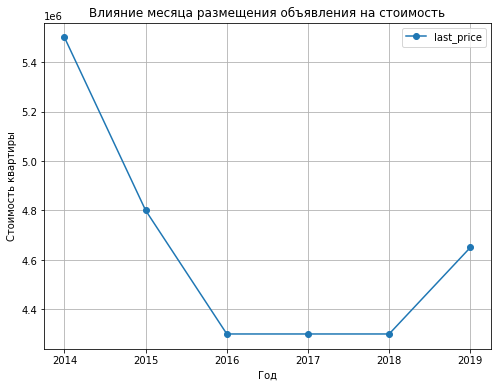

In [136]:
good_data.pivot_table(index='year', values='last_price', aggfunc='median').plot(y='last_price', style='o-', grid=True, figsize=(8,6))
plt.title('Влияние месяца размещения объявления на стоимость')
plt.xlabel("Год")
plt.ylabel("Стоимость квартиры")
plt.show()

Цены на квартиры резко упали в 2015 году и продолжали быть низкими до 2018 года. После чего рынок начал восстанавливаться и цены продолжали расти вплоть до 2019 года

#### Средняя цена 1 кв.м. в 10 населённых пунктах с наибольшим числом объявлений

In [137]:
top_10 = good_data.pivot_table(index='locality_name', values='price_per_sqm', aggfunc=['count', 'mean'])
top_10.columns = ['count', 'mean_price_per_sqm']
top_10.sort_values(by='count', ascending=False)[:10]

,count,mean_price_per_sqm
locality_name,,
Санкт-Петербург,12069,104462.591847
поселок Мурино,545,85621.045872
поселок Шушары,405,78076.545679
Всеволожск,335,66943.844776
Колпино,302,74668.321192
поселок Парголово,296,89508.337838
деревня Кудрово,296,92343.753378
Пушкин,283,99694.413428
Гатчина,264,67822.299242


Самая высокая стоимость жилья в Санкт-Петербурге - 104462 рублей за квадратный метр, а самая низкая в Выборге - 57228 рублей за квадратный метр.

#### Зависимость стоимости квартир от расстояния до центра города

Изучим предложения квартир. Выделим квартиры в Санкт-Петербурге и выясним среднюю цену каждого километра.

In [138]:
spb_flats = good_data.copy()
spb_flats = spb_flats.loc[spb_flats['locality_name'] == 'Санкт-Петербург']

In [139]:
spb_flats.groupby('city_center_dist_km')['last_price'].agg('mean').apply('{0:.0f}'.format).reset_index().set_index('city_center_dist_km')

,last_price
city_center_dist_km,
0.0,8053333
1.0,8439273
2.0,7913615
3.0,7253809
4.0,7643264
5.0,7601362
6.0,7079809
7.0,6651007
8.0,6529706


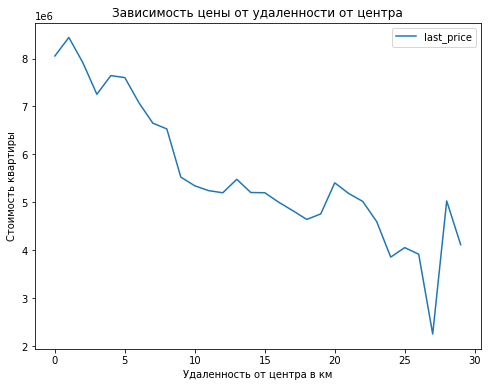

In [140]:
spb_flats.pivot_table(index='city_center_dist_km', values='last_price').plot(figsize=(8,6))
plt.title('Зависимость цены от удаленности от центра')
plt.xlabel('Удаленность от центра в км')
plt.ylabel('Стоимость квартиры')
plt.show()

Из графика видно, что цена начинает резко падать после отметки в 9км. Таким образом центральная зона Санкт-Петербурга имеет радиус 9км. На графике также видны скачки в районе 20км и 28км - это могут быть квартиры в районе Каменного острова, где жилье стоит дороже.

### Общий вывод

В процессе изучения в данных обнаружились пропущенные значения и аномалии. Пропущенные значения в столбце `balcony` заполнили 0. Пропуски в `ceiling_height` заполнили медианными значениями. Заменили пропущенные значения в `floors_total` значением этаж, на котором находится квартира + 1, чтобы не сделать этаж последним. Удалили недостающие данные в столбце `locality_name`. Пропуски в столбце `kitchen_area` для квартир-студий заменили на 0, затем остальные пропуски, а также пропуски в столбце `living_area` заменили медианными значениями. Исправили стиль заголовков в столбце `cityCenters_nearest` и переименовали некоторые столбцы. Изменили тип данных в столбцах `balcony`, `last_price` и `floors_total` на `int` для удобства проведения расчетов, а также поменяли тип в столбце `first_day_exposition` на `datetime`. После этого добавили в таблицу расчеты цены квадратного метра, день, месяц и год публикации объявления, разбили этаж квартиры на категории и перевели расстояние до центра города в километры. Затем провели исследовательский анализ данных и изучили факторы, влияющие на стоимость квартиры.

В ходе анализа данных получили следующие результаты:

**Выявили параметры влияющие на цену квартиры:**

* Общая площадь квартиры
* Жилая площадь квартиры
* Количество комнат
* Тип этажа
* Дата размещения объявления
* Близость к центру

**Найдены следующие особенности:**

* От дня размещения объявления до продажи квартиры обычно проходит 92-169 дней
* Дороже всего квадратный метр стоит в Санкт-Петербурге (104462 рублей за квадратный метр), а дешевле всего в Выборге (57228 рублей за квадратный метр)
* Квартиры в центре Санкт-Петербурга (в радиусе 9 км), а также кватриры на удалении 20 и 28 км (в районе Каменного острова) в среднем стоят дороже, чем в других районах города

    
Также можно отметить, что при исследовании цены и площади квартир было обнаружено большое число выбивающиеся значений. Эти данные могут представлять собой сегмент элитной недвижимости. При дальнейших исследованиях было бы правильным выделить данные в отельный сегмент и исследовать дополнительно.
